In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
!pip install split-folders

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  8 02:47:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
ls

archive.zip  sample_data/


In [4]:
!unzip archive.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Dataset/with_mask/1890.png  
  inflating: Dataset/with_mask/1891.png  
  inflating: Dataset/with_mask/1892.png  
  inflating: Dataset/with_mask/1893.png  
  inflating: Dataset/with_mask/1894.png  
  inflating: Dataset/with_mask/1895.png  
  inflating: Dataset/with_mask/1896.png  
  inflating: Dataset/with_mask/1897.png  
  inflating: Dataset/with_mask/1898.png  
  inflating: Dataset/with_mask/1899.png  
  inflating: Dataset/with_mask/19.png  
  inflating: Dataset/with_mask/190.png  
  inflating: Dataset/with_mask/1900.png  
  inflating: Dataset/with_mask/1901.png  
  inflating: Dataset/with_mask/1902.png  
  inflating: Dataset/with_mask/1903.png  
  inflating: Dataset/with_mask/1904.png  
  inflating: Dataset/with_mask/1905.png  
  inflating: Dataset/with_mask/1906.png  
  inflating: Dataset/with_mask/1907.png  
  inflating: Dataset/with_mask/1908.png  
  inflating: Dataset/with_mask/1909.png  
  inflating: Dataset/with_mask/191.png  
  inflating

In [5]:
import splitfolders
splitfolders.ratio('Dataset', output="./", seed=100, ratio=(.9, .1)) 

Copying files: 8982 files [00:01, 7612.46 files/s]


In [6]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True, vertical_flip = True, zoom_range = 0.1,
    shear_range = 0.1, width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 90,
)
test_data_generator = keras.preprocessing.image.ImageDataGenerator()

In [7]:
train_data = train_data_generator.flow_from_directory("./train", target_size = (128, 128), batch_size = 1, shuffle = True)
test_data = test_data_generator.flow_from_directory("./val", target_size = (128,128), batch_size = 1, shuffle = True)

Found 8082 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [8]:
labels =train_data.class_indices
labels

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [9]:
def get_array_from_datagen(train_generator):
    x=[]
    y=[]
    train_generator.reset()
    for i in range(train_generator.__len__()):
        a,b=train_generator.next()
        x.append(a)
        y.append(b)
    x=np.array(x, dtype = np.float32)
    y=np.array(y, dtype = np.float32)
    print(x.shape)
    print(y.shape)
    return x,y

X_train, y_train = get_array_from_datagen(train_data)
X_test, y_test = get_array_from_datagen(test_data)

(8082, 1, 128, 128, 3)
(8082, 1, 3)
(900, 1, 128, 128, 3)
(900, 1, 3)


In [10]:
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
y_train = y_train.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

In [34]:
## CNN

In [11]:
import gc
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl

input_shape = (128, 128, 3)
class_num = len(labels)

def cnn1():
    return Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(class_num, activation='softmax')
    ])

In [12]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 0,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [13]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [37]:
model = cnn1()
model.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
history = model.fit(X_train, y_train ,epochs=25, validation_data=(X_test, y_test),
                    verbose=2, callbacks = [learning_rate_reduction, early_stopping])
gc.collect()

Epoch 1/25
253/253 - 15s - loss: 2.0843 - accuracy: 0.6842 - val_loss: 0.4481 - val_accuracy: 0.8378 - lr: 0.0010 - 15s/epoch - 58ms/step
Epoch 2/25
253/253 - 5s - loss: 0.5437 - accuracy: 0.7883 - val_loss: 0.4655 - val_accuracy: 0.8156 - lr: 0.0010 - 5s/epoch - 22ms/step
Epoch 3/25
253/253 - 5s - loss: 0.5198 - accuracy: 0.7941 - val_loss: 3.0480 - val_accuracy: 0.5589 - lr: 0.0010 - 5s/epoch - 22ms/step
Epoch 4/25
253/253 - 5s - loss: 0.4803 - accuracy: 0.8098 - val_loss: 0.4618 - val_accuracy: 0.8189 - lr: 0.0010 - 5s/epoch - 22ms/step
Epoch 5/25
253/253 - 5s - loss: 0.4244 - accuracy: 0.8344 - val_loss: 0.3645 - val_accuracy: 0.8467 - lr: 5.0000e-04 - 5s/epoch - 22ms/step
Epoch 6/25
253/253 - 5s - loss: 0.4012 - accuracy: 0.8357 - val_loss: 0.3687 - val_accuracy: 0.8533 - lr: 5.0000e-04 - 5s/epoch - 22ms/step
Epoch 7/25
253/253 - 5s - loss: 0.3678 - accuracy: 0.8528 - val_loss: 0.3997 - val_accuracy: 0.8622 - lr: 5.0000e-04 - 5s/epoch - 21ms/step
Epoch 8/25
253/253 - 5s - loss: 0.

1689

In [14]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [39]:
model.save("CNN1")

INFO:tensorflow:Assets written to: CNN1/assets


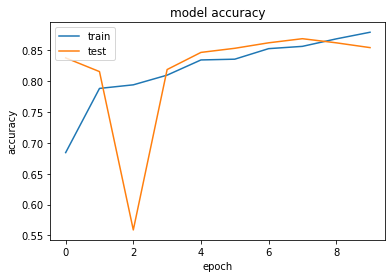

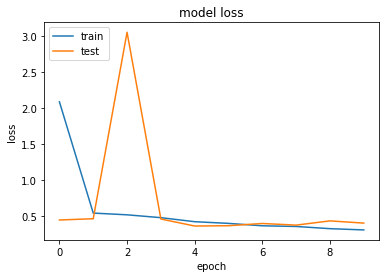

In [41]:
plot_history(history)

In [42]:
def cnn2():
    return Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(class_num, activation='softmax')
    ])

In [43]:
model = cnn2()
model.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
history = model.fit(X_train, y_train ,epochs=25, validation_data=(X_test, y_test),
                    verbose=2, callbacks = [learning_rate_reduction, early_stopping])
gc.collect()

Epoch 1/25
253/253 - 6s - loss: 0.8635 - accuracy: 0.7544 - val_loss: 0.7178 - val_accuracy: 0.7100 - lr: 0.0010 - 6s/epoch - 23ms/step
Epoch 2/25
253/253 - 5s - loss: 0.4944 - accuracy: 0.7965 - val_loss: 0.4976 - val_accuracy: 0.8489 - lr: 0.0010 - 5s/epoch - 18ms/step
Epoch 3/25
253/253 - 5s - loss: 0.4561 - accuracy: 0.8106 - val_loss: 0.5239 - val_accuracy: 0.8100 - lr: 0.0010 - 5s/epoch - 18ms/step
Epoch 4/25
253/253 - 5s - loss: 0.4528 - accuracy: 0.8145 - val_loss: 0.5578 - val_accuracy: 0.7878 - lr: 0.0010 - 5s/epoch - 18ms/step
Epoch 5/25
253/253 - 5s - loss: 0.4335 - accuracy: 0.8242 - val_loss: 0.5021 - val_accuracy: 0.7944 - lr: 0.0010 - 5s/epoch - 18ms/step
Epoch 6/25
253/253 - 5s - loss: 0.3705 - accuracy: 0.8453 - val_loss: 0.4295 - val_accuracy: 0.8267 - lr: 5.0000e-04 - 5s/epoch - 18ms/step
Epoch 7/25
253/253 - 5s - loss: 0.3346 - accuracy: 0.8599 - val_loss: 0.4162 - val_accuracy: 0.8433 - lr: 5.0000e-04 - 5s/epoch - 18ms/step
Epoch 8/25
253/253 - 5s - loss: 0.3254 -

28403

In [45]:
model.save("CNN2")

INFO:tensorflow:Assets written to: CNN2/assets


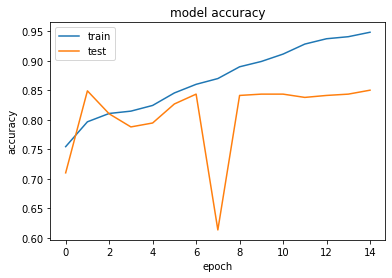

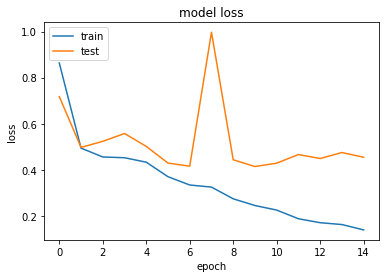

In [44]:
plot_history(history)

In [46]:
def cnn3():
    return Sequential([
        Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(class_num, activation='softmax')
    ])

In [47]:
model = cnn3()
model.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
history = model.fit(X_train, y_train ,epochs=25, validation_data=(X_test, y_test),
                    verbose=2, callbacks = [learning_rate_reduction, early_stopping])
gc.collect()


Epoch 1/25
253/253 - 23s - loss: 1.5390 - accuracy: 0.7273 - val_loss: 1.0282 - val_accuracy: 0.5244 - lr: 0.0010 - 23s/epoch - 91ms/step
Epoch 2/25
253/253 - 20s - loss: 0.6290 - accuracy: 0.7647 - val_loss: 0.8131 - val_accuracy: 0.6400 - lr: 0.0010 - 20s/epoch - 78ms/step
Epoch 3/25
253/253 - 20s - loss: 0.5400 - accuracy: 0.7857 - val_loss: 1.1880 - val_accuracy: 0.4000 - lr: 0.0010 - 20s/epoch - 78ms/step
Epoch 4/25
253/253 - 20s - loss: 0.4794 - accuracy: 0.8099 - val_loss: 1.0036 - val_accuracy: 0.5100 - lr: 0.0010 - 20s/epoch - 78ms/step
Epoch 5/25
253/253 - 20s - loss: 0.4717 - accuracy: 0.8122 - val_loss: 0.6329 - val_accuracy: 0.7633 - lr: 0.0010 - 20s/epoch - 78ms/step
Epoch 6/25
253/253 - 20s - loss: 0.4115 - accuracy: 0.8396 - val_loss: 0.7132 - val_accuracy: 0.6933 - lr: 0.0010 - 20s/epoch - 78ms/step
Epoch 7/25
253/253 - 20s - loss: 0.3750 - accuracy: 0.8534 - val_loss: 0.5690 - val_accuracy: 0.7922 - lr: 0.0010 - 20s/epoch - 78ms/step
Epoch 8/25
253/253 - 20s - loss: 0

26481

In [49]:
model.save("CNN3")

INFO:tensorflow:Assets written to: CNN3/assets


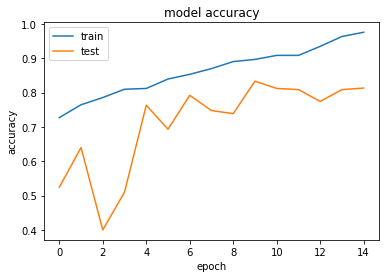

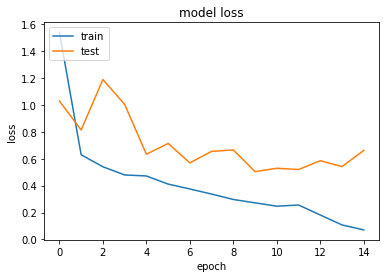

In [48]:
plot_history(history)

## RESNET

In [16]:
base_model = tf.keras.applications.ResNet50(include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [17]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)


Epoch 1/25
253/253 [==============================] - 34s 84ms/step - loss: 0.5042 - accuracy: 0.8372 - val_loss: 2.3434 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 20s 78ms/step - loss: 0.2412 - accuracy: 0.9155 - val_loss: 0.3073 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 20s 79ms/step - loss: 0.1736 - accuracy: 0.9401 - val_loss: 0.4185 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 20s 78ms/step - loss: 0.1492 - accuracy: 0.9472 - val_loss: 0.3655 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 20s 78ms/step - loss: 0.1082 - accuracy: 0.9608 - val_loss: 0.4538 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 20s 78ms/step - loss: 0.0393 - accuracy: 0.9859 - val_loss: 0.1144 - val_accuracy: 0.9667 - lr: 5.0000e-04
Epoch 7/25
253/253 [==============================] - 

In [19]:
model.save("ResNet50")

INFO:tensorflow:Assets written to: ResNet50/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


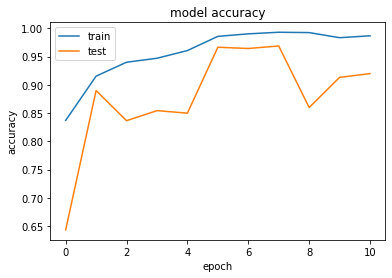

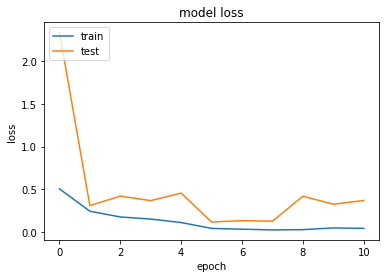

In [18]:
plot_history(history)

In [20]:
base_model = tf.keras.applications.ResNet101(include_top=False)

171458560/171446536 [==============================] - 1s 0us/step


In [21]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 44s 135ms/step - loss: 0.6862 - accuracy: 0.7820 - val_loss: 428.2953 - val_accuracy: 0.4011 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 32s 128ms/step - loss: 0.6178 - accuracy: 0.8038 - val_loss: 205.9664 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 32s 128ms/step - loss: 0.4338 - accuracy: 0.8447 - val_loss: 0.3058 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 32s 128ms/step - loss: 0.3097 - accuracy: 0.8874 - val_loss: 0.4404 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 32s 128ms/step - loss: 0.2549 - accuracy: 0.9096 - val_loss: 0.3939 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 32s 128ms/step - loss: 0.2168 - accuracy: 0.9251 - val_loss: 0.4182 - val_accuracy: 0.8322 - lr: 0.0010
Epoch 7/25
253/253 [============================

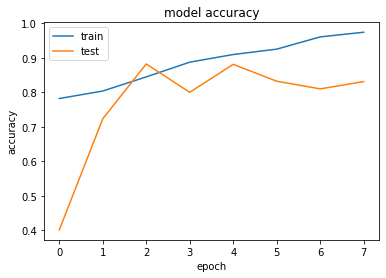

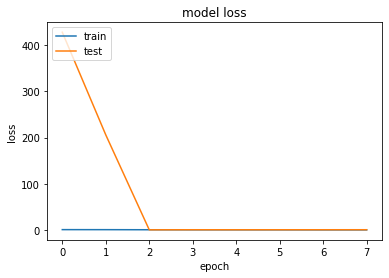

In [22]:
plot_history(history)

In [23]:
base_model = tf.keras.applications.ResNet152(include_top=False)

234708992/234698864 [==============================] - 1s 0us/step


In [24]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 63s 190ms/step - loss: 0.7466 - accuracy: 0.7460 - val_loss: 29.3051 - val_accuracy: 0.3344 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 46s 181ms/step - loss: 0.4821 - accuracy: 0.8164 - val_loss: 0.9624 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 46s 180ms/step - loss: 0.3410 - accuracy: 0.8748 - val_loss: 0.3441 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 46s 180ms/step - loss: 0.2674 - accuracy: 0.9024 - val_loss: 0.4974 - val_accuracy: 0.8378 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 46s 180ms/step - loss: 0.2297 - accuracy: 0.9198 - val_loss: 0.8281 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 46s 181ms/step - loss: 0.1828 - accuracy: 0.9370 - val_loss: 0.2966 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 7/25
253/253 [==============================]

In [25]:
model.save("ResNet152")

INFO:tensorflow:Assets written to: ResNet152/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


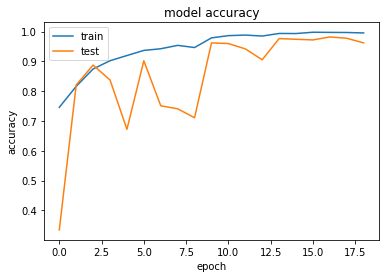

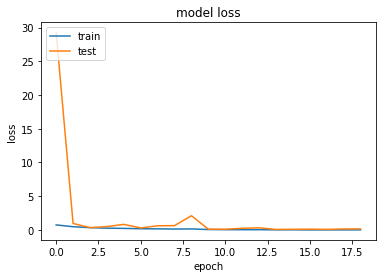

In [26]:
plot_history(history)

In [27]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)

94683136/94668760 [==============================] - 1s 0us/step


In [28]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 24s 78ms/step - loss: 0.6614 - accuracy: 0.7728 - val_loss: 26.8004 - val_accuracy: 0.4356 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 19s 73ms/step - loss: 0.5895 - accuracy: 0.7958 - val_loss: 429.6508 - val_accuracy: 0.3411 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 19s 73ms/step - loss: 0.5062 - accuracy: 0.8116 - val_loss: 0.4738 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 19s 73ms/step - loss: 0.4089 - accuracy: 0.8508 - val_loss: 0.2894 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 18s 73ms/step - loss: 0.3196 - accuracy: 0.8807 - val_loss: 0.2455 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 19s 73ms/step - loss: 0.2455 - accuracy: 0.9104 - val_loss: 0.9392 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 7/25
253/253 [==============================] - 1

In [29]:
model.save("ResNet50V2")

INFO:tensorflow:Assets written to: ResNet50V2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


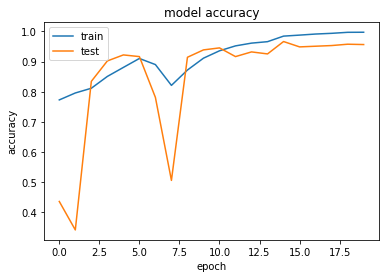

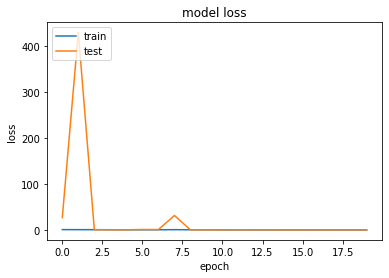

In [30]:
plot_history(history)

In [31]:
base_model = tf.keras.applications.ResNet152V2(include_top=False)

234561536/234545216 [==============================] - 1s 0us/step


In [32]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 62s 189ms/step - loss: 0.5980 - accuracy: 0.7862 - val_loss: 148046.8125 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 45s 179ms/step - loss: 0.4411 - accuracy: 0.8372 - val_loss: 1.2244 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 45s 179ms/step - loss: 0.5073 - accuracy: 0.8156 - val_loss: 0.6187 - val_accuracy: 0.8511 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 45s 179ms/step - loss: 0.3509 - accuracy: 0.8722 - val_loss: 0.2628 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 45s 179ms/step - loss: 0.2395 - accuracy: 0.9112 - val_loss: 0.1953 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 45s 179ms/step - loss: 0.1974 - accuracy: 0.9286 - val_loss: 0.2784 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 7/25
253/253 [===========================

In [33]:
model.save("ResNet1522V2")

INFO:tensorflow:Assets written to: ResNet1522V2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


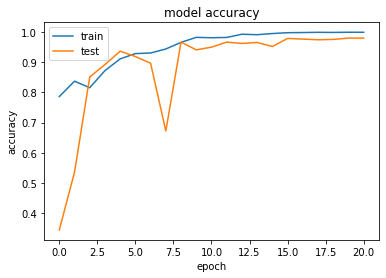

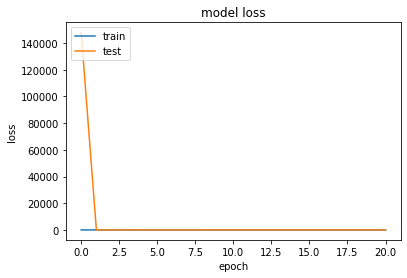

In [34]:
plot_history(history)

## InceptionV3

In [35]:
base_model = tf.keras.applications.InceptionV3(include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [36]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 27s 82ms/step - loss: 0.4996 - accuracy: 0.8242 - val_loss: 2.3149 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 19s 74ms/step - loss: 0.4431 - accuracy: 0.8567 - val_loss: 1.7601 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 19s 74ms/step - loss: 0.2987 - accuracy: 0.8898 - val_loss: 0.2270 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 19s 74ms/step - loss: 0.1958 - accuracy: 0.9306 - val_loss: 0.1354 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 19s 74ms/step - loss: 0.1321 - accuracy: 0.9515 - val_loss: 0.1257 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 19s 74ms/step - loss: 0.1426 - accuracy: 0.9550 - val_loss: 1.0738 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 7/25
253/253 [==============================] - 19s 

In [37]:
model.save("InceptionV3")

INFO:tensorflow:Assets written to: InceptionV3/assets


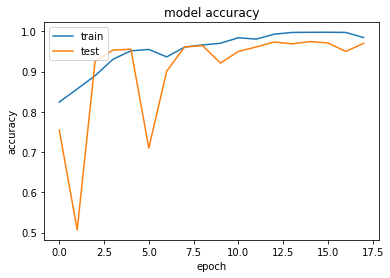

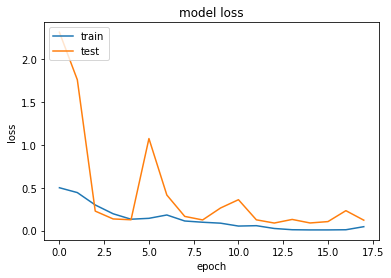

In [38]:
plot_history(history)

In [39]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False)

219070464/219055592 [==============================] - 1s 0us/step


In [40]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 61s 175ms/step - loss: 0.3161 - accuracy: 0.8972 - val_loss: 3.3771 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 41s 161ms/step - loss: 0.1545 - accuracy: 0.9493 - val_loss: 0.1154 - val_accuracy: 0.9589 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 41s 161ms/step - loss: 0.0745 - accuracy: 0.9759 - val_loss: 0.0832 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 41s 161ms/step - loss: 0.0932 - accuracy: 0.9682 - val_loss: 0.1003 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 42s 168ms/step - loss: 0.0454 - accuracy: 0.9855 - val_loss: 0.2104 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 41s 162ms/step - loss: 0.0973 - accuracy: 0.9701 - val_loss: 74.5107 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 7/25
253/253 [==============================]

In [41]:
model.save("InceptionResNetV2")

INFO:tensorflow:Assets written to: InceptionResNetV2/assets


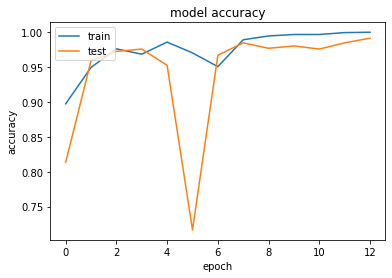

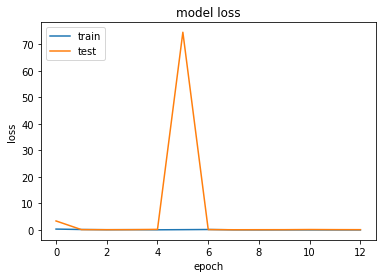

In [42]:
plot_history(history)

## DenseNet

In [43]:
base_model = tf.keras.applications.DenseNet121(include_top=False)

29097984/29084464 [==============================] - 0s 0us/step


In [44]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 35s 99ms/step - loss: 0.4242 - accuracy: 0.8534 - val_loss: 0.7388 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 23s 90ms/step - loss: 0.1787 - accuracy: 0.9376 - val_loss: 0.1325 - val_accuracy: 0.9589 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 23s 90ms/step - loss: 0.1344 - accuracy: 0.9546 - val_loss: 0.1547 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 23s 89ms/step - loss: 0.0911 - accuracy: 0.9683 - val_loss: 0.3631 - val_accuracy: 0.9044 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 23s 89ms/step - loss: 0.0850 - accuracy: 0.9709 - val_loss: 0.2877 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 23s 90ms/step - loss: 0.0790 - accuracy: 0.9727 - val_loss: 0.6967 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 7/25
253/253 [==============================] - 23s 

In [45]:
model.save("DenseNet121")

INFO:tensorflow:Assets written to: DenseNet121/assets


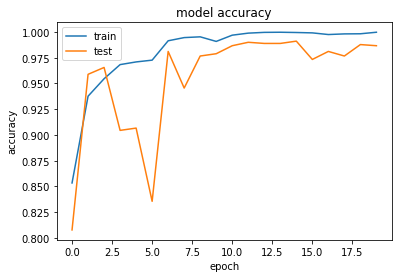

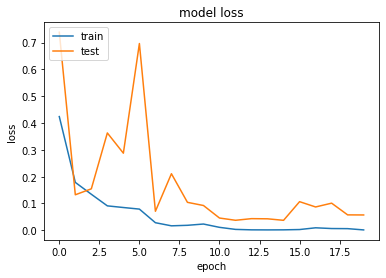

In [46]:
plot_history(history)

In [47]:
base_model = tf.keras.applications.DenseNet201(include_top=False)

74850304/74836368 [==============================] - 0s 0us/step


In [48]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 58s 153ms/step - loss: 0.4190 - accuracy: 0.8510 - val_loss: 1.8112 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 35s 138ms/step - loss: 0.3043 - accuracy: 0.8977 - val_loss: 0.6902 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 35s 138ms/step - loss: 0.1898 - accuracy: 0.9342 - val_loss: 5.4752 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 35s 138ms/step - loss: 0.1782 - accuracy: 0.9374 - val_loss: 0.1708 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 35s 138ms/step - loss: 0.1217 - accuracy: 0.9604 - val_loss: 0.1085 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 35s 138ms/step - loss: 0.1031 - accuracy: 0.9659 - val_loss: 0.2830 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 7/25
253/253 [==============================] 

In [49]:
model.save("DenseNet201")

INFO:tensorflow:Assets written to: DenseNet201/assets


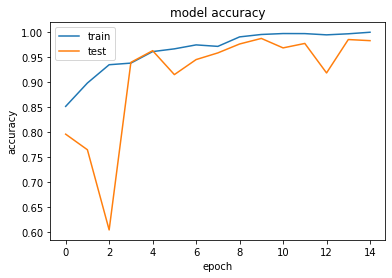

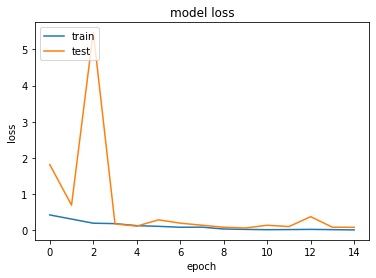

In [51]:
plot_history(history)

## EfficientNet

In [52]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16719872/16705208 [==============================] - 0s 0us/step


In [53]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 32s 94ms/step - loss: 0.2005 - accuracy: 0.9268 - val_loss: 0.1812 - val_accuracy: 0.9411 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 22s 88ms/step - loss: 0.0715 - accuracy: 0.9757 - val_loss: 0.1405 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 22s 87ms/step - loss: 0.0530 - accuracy: 0.9839 - val_loss: 0.0563 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 22s 88ms/step - loss: 0.0396 - accuracy: 0.9868 - val_loss: 0.1647 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 22s 88ms/step - loss: 0.0351 - accuracy: 0.9891 - val_loss: 0.0577 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 22s 88ms/step - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.2476 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 7/25
253/253 [==============================] - 22s 

In [54]:
model.save("EfficientNetB0")

INFO:tensorflow:Assets written to: EfficientNetB0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


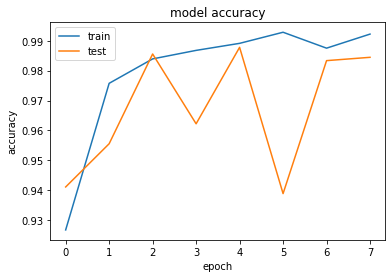

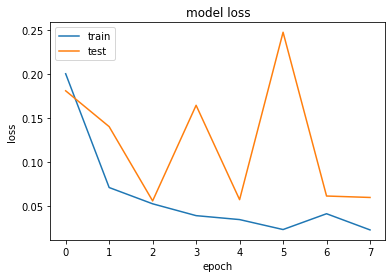

In [55]:
plot_history(history)

In [56]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)

43950080/43941136 [==============================] - 0s 0us/step


In [57]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 55s 163ms/step - loss: 0.2391 - accuracy: 0.9177 - val_loss: 0.5877 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 39s 153ms/step - loss: 0.0917 - accuracy: 0.9707 - val_loss: 0.0905 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 38s 152ms/step - loss: 0.0588 - accuracy: 0.9826 - val_loss: 0.2014 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 39s 152ms/step - loss: 0.0419 - accuracy: 0.9869 - val_loss: 0.0679 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 38s 152ms/step - loss: 0.0356 - accuracy: 0.9881 - val_loss: 0.1051 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 38s 152ms/step - loss: 0.0433 - accuracy: 0.9864 - val_loss: 0.0432 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 7/25
253/253 [==============================] 

In [58]:
model.save("EfficientNetB3")

INFO:tensorflow:Assets written to: EfficientNetB3/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


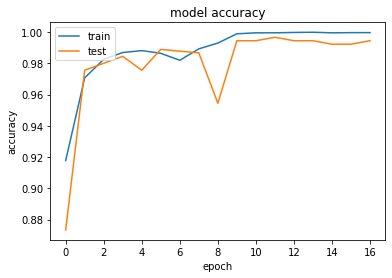

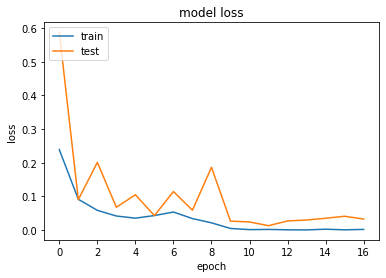

In [59]:
plot_history(history)

In [60]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False)

258088960/258076736 [==============================] - 2s 0us/step


In [61]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/25
253/253 [==============================] - 138s 437ms/step - loss: 0.2281 - accuracy: 0.9206 - val_loss: 0.1493 - val_accuracy: 0.9411 - lr: 0.0010
Epoch 2/25
253/253 [==============================] - 106s 419ms/step - loss: 0.0867 - accuracy: 0.9728 - val_loss: 0.1087 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 3/25
253/253 [==============================] - 106s 419ms/step - loss: 0.0647 - accuracy: 0.9783 - val_loss: 0.0561 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 4/25
253/253 [==============================] - 106s 419ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.1091 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 5/25
253/253 [==============================] - 106s 420ms/step - loss: 0.0374 - accuracy: 0.9878 - val_loss: 0.0519 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 6/25
253/253 [==============================] - 106s 419ms/step - loss: 0.0222 - accuracy: 0.9915 - val_loss: 0.0510 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 7/25
253/253 [==========================

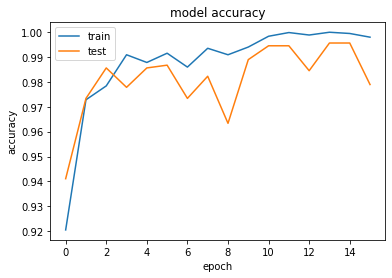

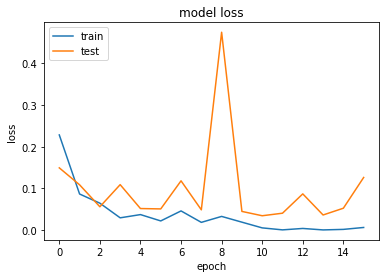

In [62]:
plot_history(history)

In [63]:
model.save("EfficientNetB7")

INFO:tensorflow:Assets written to: EfficientNetB7/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Report

In [65]:
model = keras.models.load_model("EfficientNetB3")

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       300
           1       1.00      0.99      0.99       300
           2       1.00      1.00      1.00       300

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



In [67]:
import os
from shutil import copyfile
os.mkdir("./test_data")
os.mkdir("./test_data/with_mask")
os.mkdir("./test_data/mask_weared_incorrect")
os.mkdir("./test_data/without_mask")

In [68]:
paths = []
names = []
k = 0
path = "./val/mask_weared_incorrect"
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("mask_weared_incorrect")
    copyfile(path + "/" + i, f"test_data/mask_weared_incorrect/{i}")
    k += 1
    if k == 8:
        break
k = 0
path = "./val/with_mask"
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("with_mask")
    copyfile(path + "/" + i, f"test_data/with_mask/{i}")
    k += 1
    if k == 8:
        break
path = "./val/without_mask"
k = 0
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("without_mask")
    copyfile(path + "/" + i,  f"test_data/without_mask/{i}")
    k += 1
    if k == 9:
        break

In [69]:
test_data_2 = test_data_generator.flow_from_directory("./test_data", target_size = (128,128), batch_size = 1, shuffle = False)

Found 25 images belonging to 3 classes.


In [70]:
print(labels)
labels_2 = {}
for k,v in labels.items():
    labels_2[v] = k
labels_2

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

In [71]:
predictions = model.predict(test_data_2).argmax(axis = 1)
pred_label = []
for i in predictions:
    pred_label.append(labels_2[i])
pred_label

['mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask']

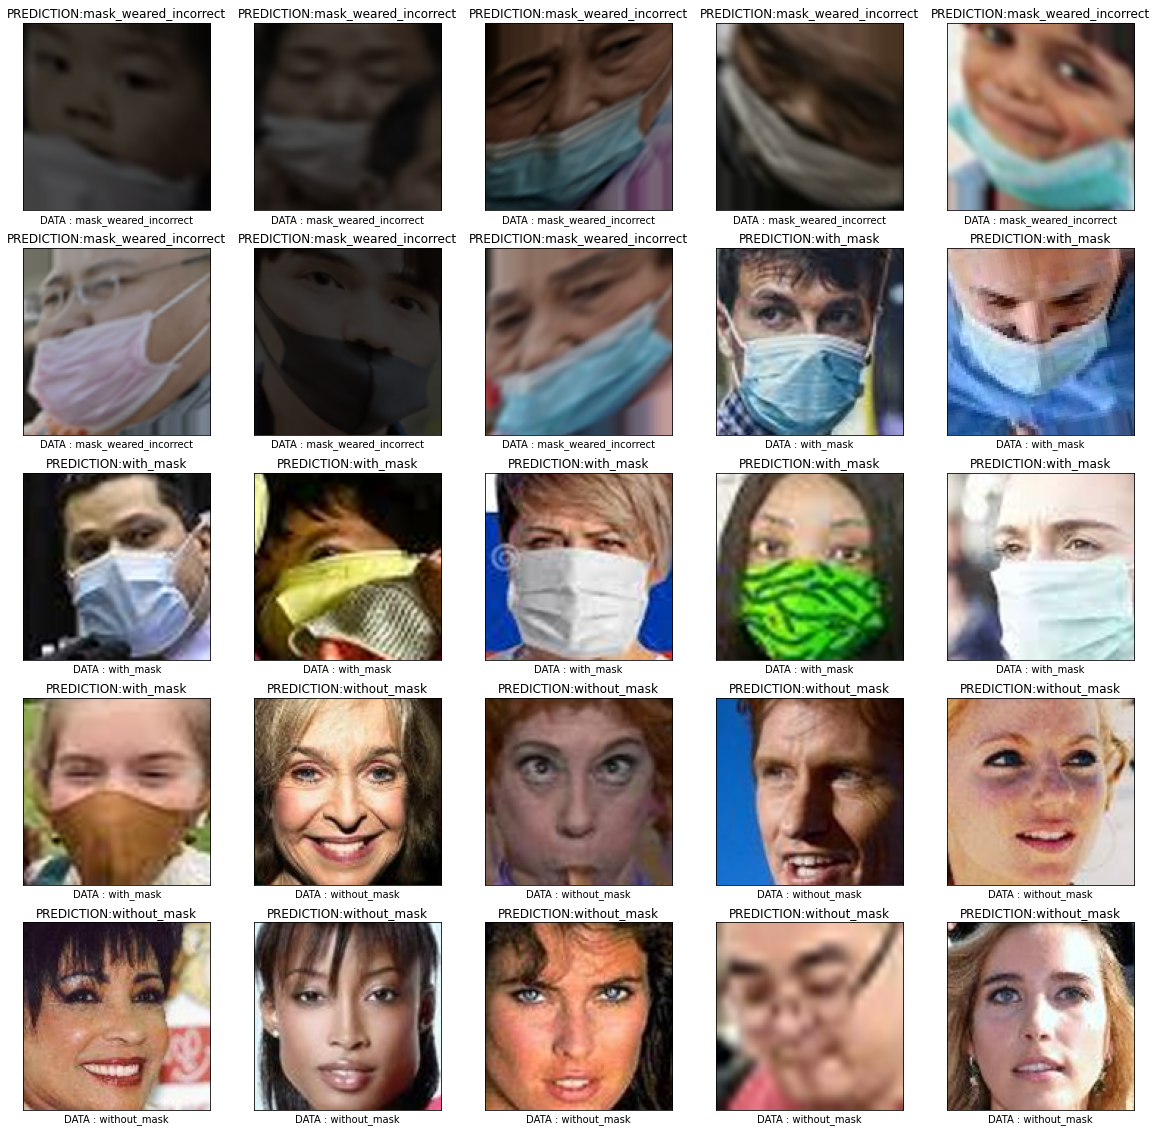

<Figure size 432x288 with 0 Axes>

In [73]:
import os
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(paths[i]))
    ax.set_title(f"PREDICTION:{pred_label[i]}")
    ax.set_xlabel(f"DATA : {names[i]}")
#plt.tight_layout()
plt.show()
plt.savefig('foo.png', bbox_inches='tight')